### Task 0 Before your go

> 1. Rename Assignment-02-###.ipynb where ### is your student ID.
> 2. The deadline of Assignment-02 is 23:59pm, 04-21-2024
> 3. In this assignment, you will use word embeddings to explore our Wikipedia dataset.

### Task 1 Train word embeddings using SGNS 
> Use our enwiki-train.json as training data. You can use the [Gensim tool](https://radimrehurek.com/gensim/models/word2vec.html). But it is recommended to implement by yourself. You should explain how hyper-parameters such as dimensionality of embeddings, window size, the parameter of negative sampling strategy, and initial learning rate have been chosen.

In [11]:
# import some necessary libraries
from typing import List, Dict, Callable
from tqdm import tqdm
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import heapq
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the train and test data from the json file

# NOTE: The function is inherited from my solution of assignment 1
def load_json(file_path: str) -> List:
    """
    Fetch the data from `.json` file and concat them into a list.

    Input:
    - file_path: The relative file path of the `.json` file

    Returns:
    - join_data_list: A list containing the data, with the format of [{'title':<>, 'label':<>, 'text':<>}, {}, ...]
    """
    join_data_list = []
    with open(file_path, "r") as json_file:
        for line in json_file:
            line = line.strip()
            # guaranteen the line is not empty
            if line: 
                join_data_list.append(json.loads(line))
    return join_data_list

train_file_path, test_file_path = "enwiki-train.json", "enwiki-test.json"
train_data_list, test_data_list = map(load_json, [train_file_path, test_file_path])

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import utils

class Word2VecWrapper(BaseEstimator, TransformerMixin):
    """
    Args:
    - vector_size: dimensionality of embeddings
    - window: window size
    - negative: the parameter of negative sampling strategy(size)
    - alpha: learning rate
    """
    def __init__(self, vector_size=100, window=5, negative=5, alpha=0.025):
        self.vector_size = vector_size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.model = None

    def fit(self, X, y=None):
        """
        Train a Word2Vec model with the specified hyperparameters.
        """
        self.model = Word2Vec(
            sentences=X,
            vector_size=self.vector_size,
            window=self.window,
            negative=self.negative,
            alpha=self.alpha
        )
        return self

    def transform(self, X):
        """
        Compute the embedding of the given X, here the average of embeddings of all words in each document is used.
        """
        doc_embeddings = []
        for text in tqdm(X):
            valid_word_embeddings = [self.model.wv[word] for word in text if word in self.model.wv]
            try:
                doc_embedding = sum(valid_word_embeddings) / len(valid_word_embeddings)
            except:
                doc_embedding = np.zeros(self.vector_size)
            doc_embeddings.append(doc_embedding)
        return doc_embeddings

- For the hyper-parameters mentioned above
  - `vector_size`: dimensionality of embeddings
    - This determines the dimensionality of the word vectors.
    - Larger size: Results in richer, more detailed word embeddings but can lead to overfitting and requires more data and memory.
    - Smaller size: Results in simpler embeddings, requires less data, and is faster to train, but might not capture nuances as effectively.
    - Common choices: Typically ranges from 50 to 300, here I choose the value from [50, 75, 100]
  - `window`: window size
    - This is the maximum distance between the current word and the words in its context that the model considers.
    - Larger window: Captures broader context, resulting in embeddings that capture more semantic information.
    - Smaller window: Focuses on local context, resulting in embeddings that capture more syntactic information.
    - Common choices: Typically ranges from 2 to 10, here I choose the value from [3, 5, 7]
  - `negative`: negative sampling strategy(size)
    - This is the number of negative samples (words) to sample for each positive sample (context word).
    - Higher value: Provides more context and potentially more informative gradients, but increases computational cost.
    - Lower value: Reduces computation and may train faster but can be less effective in learning good embeddings.
    - Common choices: Typically ranges from 5 to 20, here I choose the value from [5, 10]
  - `alpha`: initial learning rate 
    - This is the initial learning rate for the model.
    - Higher rate: Speeds up convergence but may cause the model to overshoot the optimal values.
    - Lower rate: Slows down convergence but may lead to more stable training and better results.
    - Common choices: Typically ranges from 0.01 to 0.1, here I choose the value from [0.01, 0.025, 0.05]


In [4]:
sentence = [utils.simple_preprocess(line["text"]) for line in train_data_list]
labels = [line["label"] for line in train_data_list]

pipeline = Pipeline([
    ('word2vec', Word2VecWrapper()),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100))
])

# first find the optimal learning-rate(alpha)
param_grid = {
    'word2vec__alpha': [0.01, 0.025, 0.05]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=3) 
grid_search.fit(sentence, labels)

best_params = grid_search.best_params_

# find the value other optimal hyperparameters
param_grid = {
    'word2vec__vector_size': [50, 75, 100],
    'word2vec__window': [3, 5, 7],
    'word2vec__negative': [5, 10],
    'word2vec__alpha': [best_params["word2vec__alpha"]]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=3) 
grid_search.fit(sentence, labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


100%|██████████| 200/200 [00:03<00:00, 65.90it/s] 


[CV 1/5] END ..............word2vec__alpha=0.01;, score=0.890 total time=  28.0s


100%|██████████| 200/200 [00:02<00:00, 89.53it/s] 


[CV 2/5] END ..............word2vec__alpha=0.01;, score=0.880 total time=  29.5s


100%|██████████| 200/200 [00:03<00:00, 65.19it/s] 


[CV 3/5] END ..............word2vec__alpha=0.01;, score=0.900 total time=  33.4s


100%|██████████| 200/200 [00:01<00:00, 109.58it/s]


[CV 4/5] END ..............word2vec__alpha=0.01;, score=0.890 total time=  30.8s


100%|██████████| 200/200 [00:01<00:00, 121.37it/s]


[CV 5/5] END ..............word2vec__alpha=0.01;, score=0.880 total time=  31.3s


100%|██████████| 200/200 [00:02<00:00, 67.11it/s] 


[CV 1/5] END .............word2vec__alpha=0.025;, score=0.930 total time=  29.0s


100%|██████████| 200/200 [00:02<00:00, 87.89it/s] 


[CV 2/5] END .............word2vec__alpha=0.025;, score=0.960 total time=  29.9s


100%|██████████| 200/200 [00:01<00:00, 103.58it/s]


[CV 3/5] END .............word2vec__alpha=0.025;, score=0.970 total time=  32.1s


100%|██████████| 200/200 [00:01<00:00, 105.71it/s]


[CV 4/5] END .............word2vec__alpha=0.025;, score=0.935 total time=  32.6s


100%|██████████| 200/200 [00:01<00:00, 112.61it/s]


[CV 5/5] END .............word2vec__alpha=0.025;, score=0.945 total time=  32.0s


100%|██████████| 200/200 [00:03<00:00, 63.21it/s] 


[CV 1/5] END ..............word2vec__alpha=0.05;, score=0.930 total time=  29.0s


100%|██████████| 200/200 [00:02<00:00, 83.75it/s] 


[CV 2/5] END ..............word2vec__alpha=0.05;, score=0.965 total time=  30.9s


100%|██████████| 200/200 [00:02<00:00, 93.50it/s] 


[CV 3/5] END ..............word2vec__alpha=0.05;, score=0.975 total time=  31.8s


100%|██████████| 200/200 [00:01<00:00, 104.18it/s]


[CV 4/5] END ..............word2vec__alpha=0.05;, score=0.955 total time=  31.9s


100%|██████████| 200/200 [00:01<00:00, 112.96it/s]


[CV 5/5] END ..............word2vec__alpha=0.05;, score=0.950 total time=  32.3s


100%|██████████| 1000/1000 [00:11<00:00, 86.63it/s]


Fitting 5 folds for each of 18 candidates, totalling 90 fits


100%|██████████| 200/200 [00:03<00:00, 62.42it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.925 total time=  29.4s


100%|██████████| 200/200 [00:02<00:00, 82.38it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.955 total time=  28.9s


100%|██████████| 200/200 [00:02<00:00, 96.76it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.960 total time=  29.2s


100%|██████████| 200/200 [00:01<00:00, 106.80it/s]


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.930 total time=  29.3s


100%|██████████| 200/200 [00:01<00:00, 111.89it/s]


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.945 total time=  30.2s


100%|██████████| 200/200 [00:03<00:00, 63.24it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.940 total time=  30.4s


100%|██████████| 200/200 [00:02<00:00, 86.70it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.960 total time=  29.6s


100%|██████████| 200/200 [00:03<00:00, 60.23it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.960 total time=  32.6s


100%|██████████| 200/200 [00:01<00:00, 113.99it/s]


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.940 total time=  36.6s


100%|██████████| 200/200 [00:01<00:00, 124.06it/s]


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.945 total time=  29.2s


100%|██████████| 200/200 [00:02<00:00, 67.51it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.930 total time=  27.7s


100%|██████████| 200/200 [00:02<00:00, 90.99it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.960 total time=  28.8s


100%|██████████| 200/200 [00:01<00:00, 103.12it/s]


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.975 total time=  29.4s


100%|██████████| 200/200 [00:01<00:00, 115.91it/s]


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.950 total time=  29.6s


100%|██████████| 200/200 [00:01<00:00, 119.50it/s]


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.955 total time=  30.1s


100%|██████████| 200/200 [00:02<00:00, 68.63it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.935 total time=  25.4s


100%|██████████| 200/200 [00:02<00:00, 93.15it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.960 total time=  26.7s


100%|██████████| 200/200 [00:01<00:00, 105.14it/s]


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.965 total time=  28.8s


100%|██████████| 200/200 [00:01<00:00, 111.27it/s]


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.945 total time=  27.8s


100%|██████████| 200/200 [00:01<00:00, 119.18it/s]


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.940 total time=  29.0s


100%|██████████| 200/200 [00:04<00:00, 46.60it/s]


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.930 total time=  28.9s


100%|██████████| 200/200 [00:02<00:00, 90.05it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.960 total time=  29.4s


100%|██████████| 200/200 [00:02<00:00, 91.96it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.980 total time=  29.1s


100%|██████████| 200/200 [00:02<00:00, 84.17it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.955 total time=  32.1s


100%|██████████| 200/200 [00:01<00:00, 122.94it/s]


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.945 total time=  30.0s


100%|██████████| 200/200 [00:03<00:00, 66.63it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.935 total time=  28.1s


100%|██████████| 200/200 [00:02<00:00, 91.19it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.960 total time=  29.6s


100%|██████████| 200/200 [00:01<00:00, 103.94it/s]


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.975 total time=  30.2s


100%|██████████| 200/200 [00:01<00:00, 114.62it/s]


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.945 total time=  30.3s


100%|██████████| 200/200 [00:01<00:00, 117.42it/s]


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.945 total time=  31.5s


100%|██████████| 200/200 [00:03<00:00, 59.52it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.925 total time=  31.8s


100%|██████████| 200/200 [00:02<00:00, 71.24it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.965 total time=  43.4s


100%|██████████| 200/200 [00:02<00:00, 86.69it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.960 total time=  40.2s


100%|██████████| 200/200 [00:02<00:00, 75.28it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.945 total time=  45.3s


100%|██████████| 200/200 [00:02<00:00, 81.39it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.940 total time=  46.1s


100%|██████████| 200/200 [00:04<00:00, 41.37it/s]


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.930 total time=  44.5s


100%|██████████| 200/200 [00:03<00:00, 54.22it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.960 total time=  46.2s


100%|██████████| 200/200 [00:03<00:00, 64.40it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.970 total time=  47.8s


100%|██████████| 200/200 [00:03<00:00, 65.80it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.945 total time=  48.7s


100%|██████████| 200/200 [00:02<00:00, 74.17it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.945 total time=  48.4s


100%|██████████| 200/200 [00:04<00:00, 44.88it/s]


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.930 total time=  42.9s


100%|██████████| 200/200 [00:03<00:00, 62.58it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.965 total time=  43.3s


100%|██████████| 200/200 [00:02<00:00, 67.48it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.980 total time=  43.4s


100%|██████████| 200/200 [00:02<00:00, 69.31it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.955 total time=  46.9s


100%|██████████| 200/200 [00:02<00:00, 70.82it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.955 total time=  51.3s


100%|██████████| 200/200 [00:04<00:00, 41.44it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.930 total time=  53.2s


100%|██████████| 200/200 [00:03<00:00, 53.32it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.960 total time=  55.3s


100%|██████████| 200/200 [00:02<00:00, 70.05it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.965 total time=  54.0s


100%|██████████| 200/200 [00:02<00:00, 73.97it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.930 total time=  54.4s


100%|██████████| 200/200 [00:02<00:00, 81.07it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.940 total time=  55.1s


100%|██████████| 200/200 [00:04<00:00, 46.26it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.935 total time=  51.3s


100%|██████████| 200/200 [00:03<00:00, 51.04it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.965 total time=  57.3s


100%|██████████| 200/200 [00:03<00:00, 60.65it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.965 total time= 1.1min


100%|██████████| 200/200 [00:02<00:00, 67.28it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.955 total time=  59.0s


100%|██████████| 200/200 [00:02<00:00, 82.76it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.945 total time=  58.4s


100%|██████████| 200/200 [00:04<00:00, 43.78it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.930 total time=  51.9s


100%|██████████| 200/200 [00:03<00:00, 63.90it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.960 total time=  58.8s


100%|██████████| 200/200 [00:03<00:00, 64.61it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.965 total time=  59.5s


100%|██████████| 200/200 [00:02<00:00, 69.97it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.950 total time= 1.0min


100%|██████████| 200/200 [00:02<00:00, 68.54it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.950 total time= 1.0min


100%|██████████| 200/200 [00:05<00:00, 37.75it/s]


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=3;, score=0.930 total time=  54.2s


100%|██████████| 200/200 [00:03<00:00, 58.26it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=3;, score=0.960 total time= 1.1min


100%|██████████| 200/200 [00:02<00:00, 81.96it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=3;, score=0.970 total time=  59.6s


100%|██████████| 200/200 [00:02<00:00, 74.74it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=3;, score=0.940 total time=  57.1s


100%|██████████| 200/200 [00:02<00:00, 72.48it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=3;, score=0.940 total time= 1.0min


100%|██████████| 200/200 [00:05<00:00, 39.28it/s]


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=5;, score=0.935 total time=  51.7s


100%|██████████| 200/200 [00:03<00:00, 56.22it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=5;, score=0.965 total time=  58.2s


100%|██████████| 200/200 [00:03<00:00, 66.37it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=5;, score=0.965 total time= 1.0min


100%|██████████| 200/200 [00:02<00:00, 71.50it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=5;, score=0.955 total time= 1.0min


100%|██████████| 200/200 [00:02<00:00, 74.79it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=5;, score=0.940 total time=  59.6s


100%|██████████| 200/200 [00:04<00:00, 44.19it/s] 


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=7;, score=0.935 total time=  53.2s


100%|██████████| 200/200 [00:03<00:00, 60.50it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=7;, score=0.965 total time=  52.1s


100%|██████████| 200/200 [00:03<00:00, 55.45it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=7;, score=0.975 total time=  56.7s


100%|██████████| 200/200 [00:03<00:00, 63.22it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=7;, score=0.955 total time= 1.1min


100%|██████████| 200/200 [00:02<00:00, 71.39it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=7;, score=0.950 total time= 1.1min


100%|██████████| 200/200 [00:05<00:00, 39.22it/s]


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=3;, score=0.935 total time=  56.9s


100%|██████████| 200/200 [00:03<00:00, 51.56it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=3;, score=0.965 total time=  59.7s


100%|██████████| 200/200 [00:03<00:00, 63.01it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=3;, score=0.980 total time= 1.0min


100%|██████████| 200/200 [00:02<00:00, 70.72it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=3;, score=0.945 total time= 1.0min


100%|██████████| 200/200 [00:02<00:00, 76.42it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=3;, score=0.945 total time= 1.0min


100%|██████████| 200/200 [00:06<00:00, 29.44it/s]


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=5;, score=0.925 total time= 1.1min


100%|██████████| 200/200 [00:03<00:00, 52.40it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=5;, score=0.960 total time= 1.1min


100%|██████████| 200/200 [00:03<00:00, 57.64it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=5;, score=0.980 total time= 1.2min


100%|██████████| 200/200 [00:02<00:00, 75.71it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=5;, score=0.955 total time= 1.0min


100%|██████████| 200/200 [00:02<00:00, 77.95it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=5;, score=0.945 total time= 1.0min


100%|██████████| 200/200 [00:05<00:00, 38.47it/s]


[CV 1/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=7;, score=0.930 total time=  59.2s


100%|██████████| 200/200 [00:04<00:00, 49.48it/s] 


[CV 2/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=7;, score=0.965 total time= 1.1min


100%|██████████| 200/200 [00:03<00:00, 60.52it/s] 


[CV 3/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=7;, score=0.980 total time= 1.1min


100%|██████████| 200/200 [00:03<00:00, 55.77it/s] 


[CV 4/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=7;, score=0.955 total time= 1.1min


100%|██████████| 200/200 [00:02<00:00, 66.87it/s] 


[CV 5/5] END word2vec__alpha=0.05, word2vec__negative=10, word2vec__vector_size=100, word2vec__window=7;, score=0.955 total time= 1.2min


100%|██████████| 1000/1000 [00:13<00:00, 74.38it/s]


In [5]:
# print out the best parameters of the Word2Vec model
best_params = grid_search.best_params_ if grid_search is not None \
    else {
        'word2vec__alpha': 0.05, 'word2vec__negative': 5, 'word2vec__vector_size': 100, 'word2vec__window': 7
    }

print(f"Best parameters of the Word2Vec model: {best_params}")

# use the best parameters to fit the Word2Vec model
model = Word2Vec(
    sentence, 
    vector_size=best_params["word2vec__vector_size"], window=best_params["word2vec__window"], 
    negative=best_params["word2vec__negative"], alpha=best_params["word2vec__alpha"]
)

Best parameters of the Word2Vec model: {'word2vec__alpha': 0.05, 'word2vec__negative': 5, 'word2vec__vector_size': 100, 'word2vec__window': 7}


From the result of the `GridSearchCV` above, we can find that the best parameters for the `Word2Vec` model in the training dataset is
```python
best_params = {
    'word2vec__alpha': 0.05, 'word2vec__negative': 5, 'word2vec__vector_size': 100, 'word2vec__window': 7
}
```

### Task 2 Find similar/dissimilar word pairs

> Randomly generate 100, 1000, and 10000-word pairs from the vocabularies. For each set, print 5 closest word pairs and 5 furthest word pairs (you can use cosine-similarity to measure two words). Explain your results.

In [12]:
def generate_random_paris(samples: int):
    """
    Generate random indices without replacement, then pairs the indices to get word pairs
    """
    indices = random.sample(range(len(model.wv)), 2 * samples)
    indices1, indices2 = indices[:samples], indices[samples:]
    return [model.wv.index_to_key[i] for i in indices1], [model.wv.index_to_key[i] for i in indices2]

def find_closest_furthest(num: int=5, words1: List[str]=None, words2: List[str]=None) -> None:
    """
    Find the cloest/furthest word pairs using `model.wv.similarity`.

    Here a heap queue is used to reduce time complexity to $O(n\log k)$, where k denotes the `num`
    """
    heap = []
    for i in range(len(words1)):
        # compute the similarity and push it into the heap
        heapq.heappush(heap, (model.wv.similarity(words1[i], words2[i]), words1[i], words2[i]))
    return heapq.nlargest(num, heap), heapq.nsmallest(num, heap)[::-1]

def print_word_pairs(results: List[tuple], flag: str) -> None:
    """
    Print the result in formatted string
    """
    print("The 5 {:>8} word pairs:".format(flag))
    for result in results:
       print("Word pairs: ({:>15}, {:>15}) --> Similarity: {:>8.6f}".format(result[1], result[2], result[0]))


random.seed(408)
pairs = [100, 1000, 10000]
for pair in pairs:
    print("For {:>5} random pairs from the vocabularies:".format(pair))
    cloest, furthest = find_closest_furthest(5, *generate_random_paris(pair))
    print_word_pairs(cloest, "closest")
    print_word_pairs(furthest, "furthest")
    print("-" * 70)

For   100 random pairs from the vocabularies:
The 5  closest word pairs:
Word pairs: (musculoskeletal,   communicators) --> Similarity: 0.435976
Word pairs: (      hiffernan,         augusta) --> Similarity: 0.398910
Word pairs: (        bruxing,        plumbers) --> Similarity: 0.391739
Word pairs: (         sheila,    mononeuritis) --> Similarity: 0.379485
Word pairs: (         jessie,          tehari) --> Similarity: 0.371062
The 5 furthest word pairs:
Word pairs: (          elton,        brackets) --> Similarity: -0.123771
Word pairs: (     hertzfeldt,       kaecilius) --> Similarity: -0.139694
Word pairs: (        papilla,       agitation) --> Similarity: -0.145568
Word pairs: (  manifestation,        homeless) --> Similarity: -0.146574
Word pairs: (          meant,     ahmadinejad) --> Similarity: -0.160744
----------------------------------------------------------------------
For  1000 random pairs from the vocabularies:
The 5  closest word pairs:
Word pairs: (           tofu,  

### Task 3 Present a document as an embedding

> For each document, you have several choices to generate document embedding: 1. Use the average of embeddings of all words in each document; 2. Use the first paragraph’s words and take an average on these embeddings; 3. Use the doc2vec algorithm to present each document. Do the above for both training and testing dataset

In [7]:
####################################################################################
###        1. Use the average of embeddings of all words in each document        ###
####################################################################################
def print_document_embeddings(embeddings: Dict, display: int=3) -> None:
    """
    Print the first `display` embeddings, default value is 3
    """
    count = 0
    for embedding, title in embeddings:
        if count >= display:
            break
        count += 1
        print("Title: {}\nEmbedding: {}".format(title, embedding))
        print("-" * 70)

def print_training_testing(method: Callable):
    """
    Print the embeddings for training and testing dataset
    """
    print("For the training dataset:")
    print_document_embeddings(method())
    print("-" * 70)
    print("For the  testing dataset:")
    print_document_embeddings(method(test_data_list))

def average_all_words(data_list: List[Dict]=train_data_list, mode: str="title") -> List[tuple]:
    doc_embeddings = []
    if mode not in ["title", "label"]:
        raise ValueError("Please input a valid mode: ['title', 'label']")
    for line in tqdm(data_list):
        line_text = utils.simple_preprocess(line["text"]) # preprocess the text as in class `Corpus`
        # doc title/label and doc embedding computed by averaging all words embeddings
        doc_info = line[mode]
        valid_word_embeddings = [model.wv[word] for word in line_text if word in model.wv]
        try:
            doc_embedding = sum(valid_word_embeddings) / len(valid_word_embeddings)
        except:
            doc_embedding = np.zeros(model.vector_size)
        # store the information in a dictionary
        doc_embeddings.append((doc_embedding, doc_info))

    return doc_embeddings

print_training_testing(average_all_words)


For the training dataset:
Title: Citizen_Kane
Embedding: [ 0.18590401 -0.28252226  0.05628046  0.32434854 -0.53778946  0.06316876
 -0.12789394 -0.27093416  0.0784847   0.24346621  0.2457499  -0.11399522
  0.15251535  0.09307836  0.07301798 -0.29477152 -0.0955706   0.2882937
 -0.10128127  0.15832141 -0.16076629  0.3372708   0.01844778 -0.07727255
 -0.22363277  0.21625212  0.3318612   0.11993553  0.04504227  0.03229349
 -0.00797667  0.11351699  0.4348668   0.25789908  0.44310457  0.42756906
 -0.2890097   0.01006778 -0.19640437  0.28385866  0.03254798 -0.05870871
 -0.08826407  0.09862735  0.1559093  -0.02053958 -0.3319915   0.13782093
  0.01577005 -0.12730527 -0.07534547  0.32327318 -0.15827057  0.09505395
  0.34647998  0.06520744 -0.04437676  0.07192703  0.24185278  0.15296009
  0.47872138  0.13484146  0.04908412 -0.01875386 -0.13199538 -0.13920718
 -0.24327344 -0.13182984  0.10708869  0.24601914  0.45260093  0.15401077
 -0.17505921 -0.08721434  0.28179383  0.47823215  0.13414112  0.2975

In [8]:
####################################################################################
###  2. Use the first paragraph’s words and take an average on these embeddings  ###
####################################################################################
def find_first_paragraph(text: str):
    return text.split("\n")[0]

def average_first_para_words(data_list: List[Dict]=train_data_list, mode: str="title") -> List[tuple]:
    doc_embeddings = []
    if mode not in ["title", "label"]:
        raise ValueError("Please input a valid mode: ['title', 'label']")
    for line in tqdm(data_list):
        doc_info = line[mode]
        valid_word_embeddings = [model.wv[word] for word in utils.simple_preprocess(find_first_paragraph(line["text"])) if word in model.wv]
        # since the number of words in the first paragraph is so small, it may occur `ZeroDivisonError` in the computation, here I use a 
        # try-except flow to handle this exception
        try:
            doc_embedding = sum(valid_word_embeddings) / len(valid_word_embeddings)
        except:
            doc_embedding = np.zeros(model.vector_size)
        doc_embeddings.append((doc_embedding, doc_info))

    return doc_embeddings

print_training_testing(average_first_para_words)

For the training dataset:
Title: Citizen_Kane
Embedding: [ 0.11649276 -0.4359358   0.23588423  0.43083617 -0.58933437 -0.27726212
 -0.28212714 -0.36066297 -0.16588755  0.17922239  0.03115992 -0.08441351
  0.25195172  0.07912745  0.1059823  -0.31665882 -0.11264812  0.37253568
  0.06165884 -0.20877346 -0.19647276  0.5809593   0.0555153  -0.44245327
 -0.12778062  0.3430322   0.18841566  0.3803351  -0.1934793   0.21704124
 -0.15576902  0.13474913  0.33183965 -0.05573253  0.55799574  0.7745225
 -0.0138927   0.11666355 -0.10713432  0.41988984 -0.0289993  -0.23175909
 -0.08961555  0.0670171   0.24181958 -0.10187653 -0.2908622   0.19080941
  0.00283275 -0.00755377  0.08579926  0.6654859  -0.04292916  0.06262298
  0.29333133 -0.11506709  0.11853695  0.16073045  0.3258699   0.3266987
  0.81810594  0.23988375  0.15949528 -0.11299378 -0.05636979 -0.25890628
  0.01064218 -0.20769128 -0.252424    0.21212359  0.2427457   0.15237194
 -0.09025162 -0.28909737  0.14290695  0.6894584  -0.42107072  0.37199

In [14]:
####################################################################################
###             3. Use the doc2vec algorithm to present each document            ###
####################################################################################
def build_doc2vec() -> Doc2Vec:
    """
    Build the `Doc2Vec` model based on the `train_data_list`
    """
    preprocessed_text = [utils.simple_preprocess(line["text"]) for line in train_data_list]
    tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(preprocessed_text)]
    model = Doc2Vec(
        vector_size=best_params["word2vec__vector_size"], window=best_params["word2vec__window"], 
        negative=best_params["word2vec__negative"], alpha=best_params["word2vec__alpha"]
    )
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    return model

doc2vec_model = build_doc2vec()

def doc2vec_model_embeddings(data_list: List[Dict]=train_data_list, mode: str="title") -> List[tuple]:
    embeddings = []
    if mode not in ["title", "label"]:
        raise ValueError("Please input a valid mode: ['title', 'label']")
    if data_list == train_data_list:
        for index, line in tqdm(enumerate(data_list)):
            embeddings.append((doc2vec_model.dv[str(index)], line[mode]))
    else:
        for line in tqdm(data_list):
            embeddings.append((doc2vec_model.infer_vector(line["text"].split()), line[mode]))
    return embeddings

print_training_testing(doc2vec_model_embeddings)

For the training dataset:
Title: Citizen_Kane
Embedding: [ 0.2929044   1.9721631  -1.5410775  -1.6790605   2.0315888  -1.1444315
  3.9444413  -0.9562231  -2.0205853   0.7313754   0.36821178 -2.6601148
 -0.09004695 -0.5407329   2.240854   -3.9552      2.495869   -2.1824179
 -2.3611984   0.3906504  -4.030407    3.559282    2.2488995   1.6566814
  0.03771036 -0.22702174 -1.8459136  -2.2966163  -0.36375126 -1.1884258
 -1.299227    2.351423   -2.5674188  -0.94051063 -4.464051   -1.0268047
 -4.3546104   1.3286641  -0.45972532  6.4729986  -4.0223722  -4.8587823
 -1.9881951   1.3165681   2.5238945  -0.16769117 -0.5128877   1.2640448
 -2.4582675   0.52012664 -1.9780381  -2.4267056   0.74202687 -2.1539655
 -0.19431101  1.6410482  -1.7538962  -0.85043097 -2.6786816  -0.02904887
 -0.8614109   4.4636574   2.812786   -2.244602    1.800925   -1.3625603
 -4.502579    2.4435968  -3.3930328   0.00991183 -1.5212353   2.4374404
 -1.2045667  -0.5620743  -5.0497675   1.1731899  -4.8548574   0.6928818
  5.80

### Task 4 Build classifier to test docs
> Build softmax regression model to classifier testing documents based on these training doc embeddings. Does it getting better than Naive Bayes'? (You have 3 models.)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

class softmaxModel:
    def __init__(self, data: List[Dict], method: Callable) -> None:
        self.X = None
        self.y = None
        self.label_to_index = {}
        self.__model = None
        self.__ytest = None
        self.__ypred = None
        self.__method = method               # the three different models in task 3
        self.__train(method(data, "label"))  # use `method(data)` to get the embedding

    def __train(self, embedding: List[tuple]):
        """
        Train a softmax classifier based on the embedding in train data
        """
        self.X, self.y = self.__decode(embedding)
        self.__model = LogisticRegression(multi_class="multinomial", solver="lbfgs").fit(self.X, self.y)

    def __decode(self, embedding: List[tuple]) -> tuple:
        X, y = map(list, zip(*embedding))
        X, y =  map(np.array, [X, y])
        for index, label in enumerate(y):
            self.label_to_index[label] = index
        return X, y

    def predict(self, test_data: List[Dict]) -> List:
        """
        Return the predicted value of y based on the trained model and given test data
        """
        test_embedding = self.__method(test_data, "label")
        X_test, y_test = self.__decode(test_embedding)
        self.__ytest = y_test
        self.__ypred = self.__model.predict(X_test)
        return self.__ypred

    def accuracy(self) -> float:
        """
        Calculate and return the accuracy of the model in testing dataset
        """
        return accuracy_score(self.__ytest, self.__ypred)
    
    def tsne_plot(self, samples: int=24, perplexity: float=30, n_iter: int=1000) -> None:
        """
        Use t-SNE to project training document embeddings into 2d and plot them out for each of the above choices
        """
        tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity, n_iter=n_iter)
        Z = tsne.fit_transform(self.X)
        labels = set(self.y)
        # find the title
        _, titles = self.__decode(self.__method(train_data_list, "title"))
        # plot the scatter
        plt.figure(figsize=(12, 12))
        for i, label in enumerate(labels):
            indices = [j for j, y_label in enumerate(self.y) if y_label == label]
            plt.scatter(Z[indices, 0], Z[indices, 1], label=label)
        # plot the annotation
        random.seed(0)
        selected_indices = random.sample(list(range(len(self.y))), samples)
        for i in selected_indices:
            plt.annotate(titles[i], (Z[i, 0], Z[i, 1]))
        plt.legend()
        plt.show()


methods = {
    "Use the average of embeddings of all words in each document": average_all_words, 
    "Use the first paragraph’s words and take an average on these embeddings": average_first_para_words, 
    "Use the doc2vec algorithm to present each document": doc2vec_model_embeddings
}

models = {}

random.seed(411)
for text, method in methods.items():
    softmax_model = softmaxModel(train_data_list, method)
    softmax_model.predict(test_data_list)
    print("Model: {:>71}, accuracy: {:>.2f}".format(text, softmax_model.accuracy()))
    models[text] = softmax_model
    del softmax_model


Model:             Use the average of embeddings of all words in each document, accuracy: 0.96
Model: Use the first paragraph’s words and take an average on these embeddings, accuracy: 0.94
Model:                      Use the doc2vec algorithm to present each document, accuracy: 0.92


### Task 5 Use t-SNE to project doc vectors

> Use t-SNE to project training document embeddings into 2d and plot them out for each of the above choices. Each point should have a specific color (represent a particular cluster). You may need to try different parameters of t-SNE. One can find more details about t-SNE in this [excellent article](https://distill.pub/2016/misread-tsne/).

Use the average of embeddings of all words in each document:


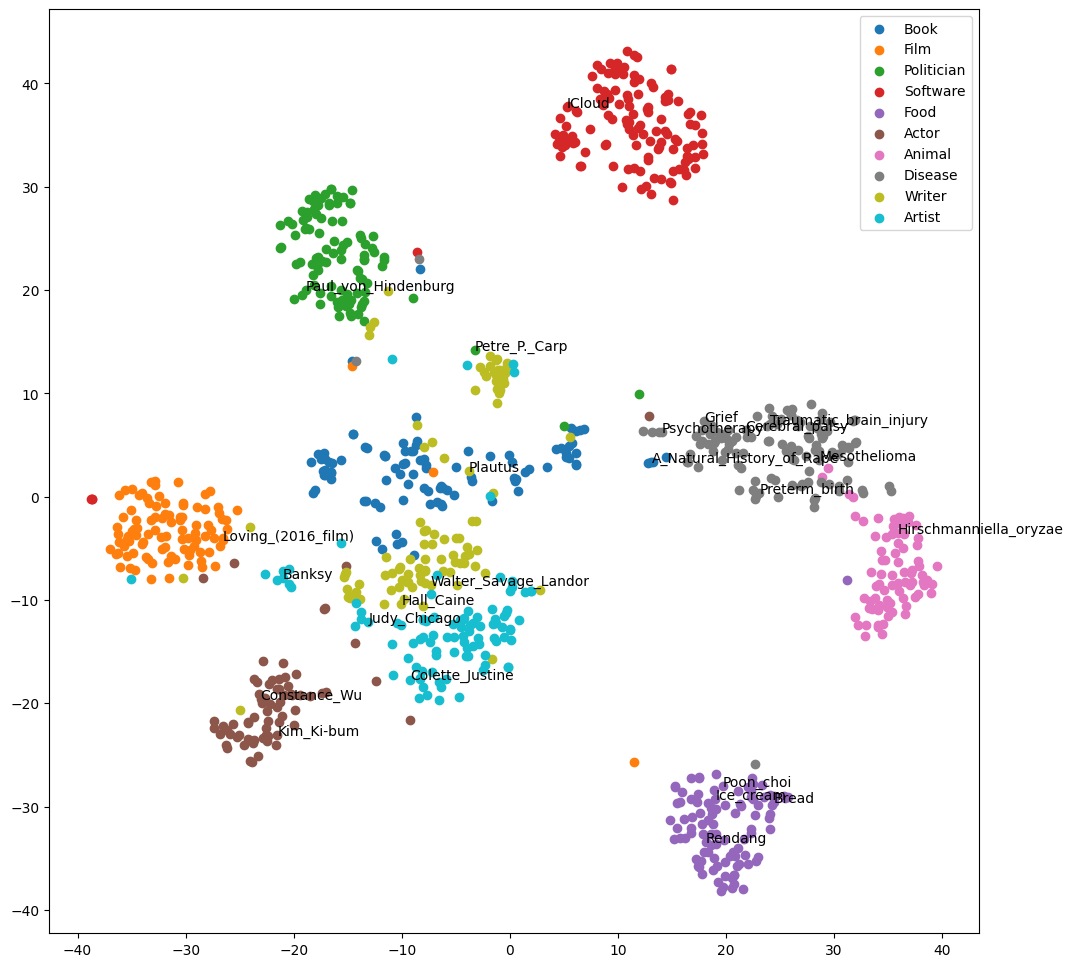

Use the first paragraph’s words and take an average on these embeddings:


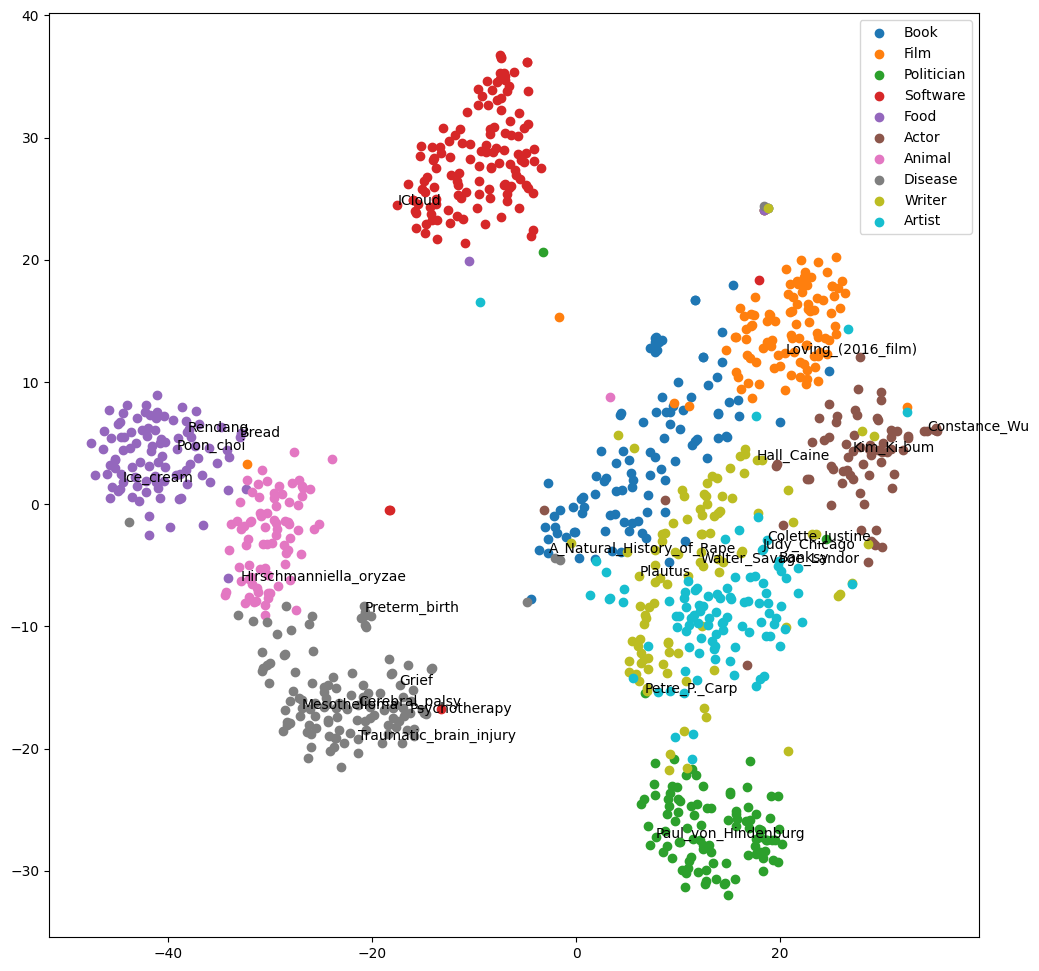

Use the doc2vec algorithm to present each document:


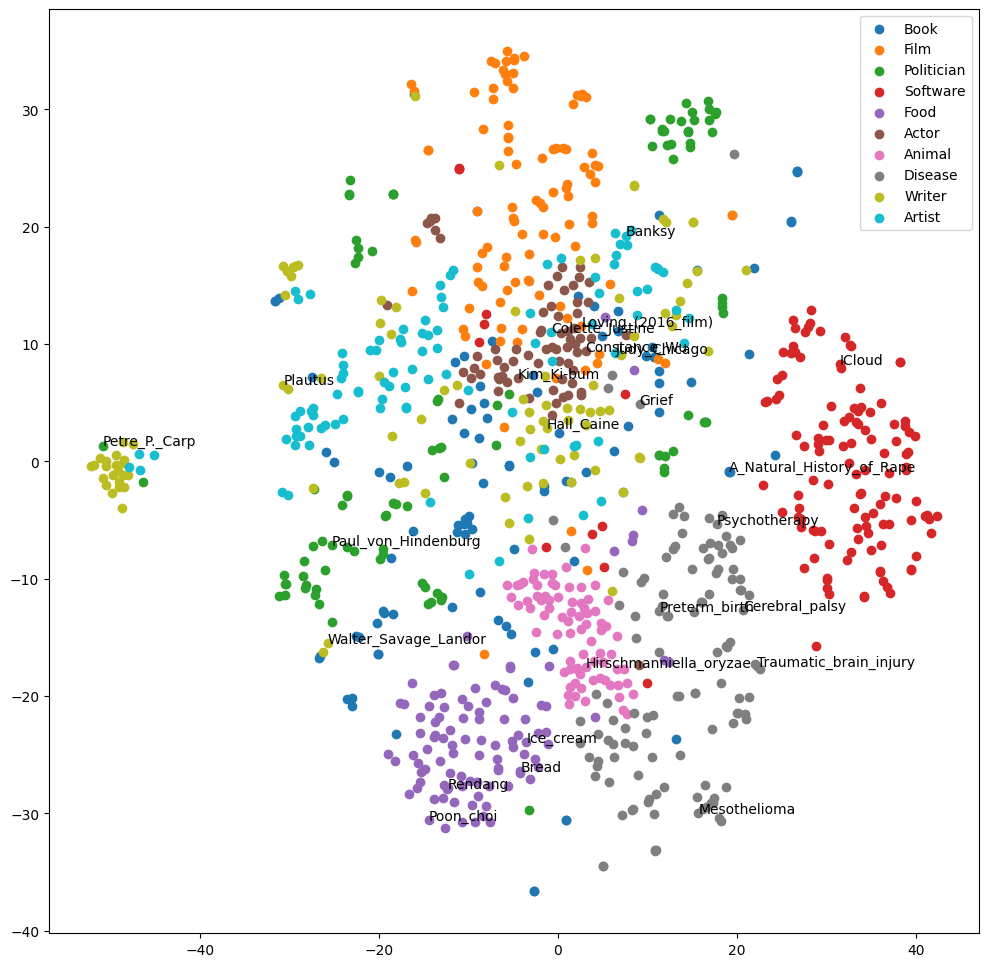

In [16]:
for text, _model in models.items():
    print(text + ":")
    _model.tsne_plot()
